# GEONE - GEOSCLASSIC - categorical variable

## Estimation (kriging) and simulation (Sequential Indicator Simulation, SIS)

The following functions are used for a grid, i.e. the evaluation are done at the centers of the grid cells:

- `geone.geosclassicinterface.estimateIndicator`: for estimation, kriging of the indicator of each category, producing probabilities of for the categories
- `geone.geosclassicinterface.simulate`: for simulation (sequential Indicator simulation, SIS)

*Note: these functions detect the space dimension (1, 2, or 3) based on the parameter `dimension` that gives the number of cells along each axis.*

These functions launch a C program running in parallel (based on *OpenMP*) for the simulation / estimation **in a grid**, assuming conditioning data located at the center of the grid cells. The conditioning data are treated as follows: (one of) the most frequent categories of the data point(s) falling in the same grid cell is attributed to that cell.

## Interpolation type (kriging type)
Estimation and simulation are done based on the kriging of the indicator of each category (consisered as a continuous variable for the presence of the category); simple kriging or ordinary kriging can be used according to the parameter `method`: 
- `method='simple_kriging'`: simple kriging
- `method='oridinary_kriging'`: ordinary kriging (default)

Kriging systems are based on a covariance model: required parameter `cov_model`. A single covariance model can be used for all the categories or a covariance model per category can be specified. See the notebook `ex_general_multiGaussian.ipynb` for available covariance models and examples. 

*Note: non-stationarities may be handled: local rotation, local multiplier for sill and/or range(s), see the notebook `ex_geosclassic_indicator_1d_2_non_stat_cov.ipynb`.*

Simple kriging allows to specify the probabilities of the presence of the categories (kriging mean values of the indicator variable), stationary (global) or non-stationary (local). By default the probabilities are set to the proportions of the data values (stationary) or uniform probabilities if no data point is present.

Ordinary kriging accounts for the proportion (mean value) at the vinicity of the estimated / simulated point. Note that one can also specify probabilities, which is used when no informed points is present in the search neighborhood of the estimated / simulated point.

## Conditioning data
Data consists of an ensemble of points, where each data point is given by a location (in the grid), a category value:
- `x`: data locations
- `v`: data category values

The conditioning data are treated as follows: (one of) the most frequent categories of the data point(s) falling in the same grid cell is attributed to that cell.

## Search neighborhood 
See notebook `ex_geosclassic_1d_1.ipynb` for details.

## Computational resources - multiprocessing
The external C function (Geos-Classic library) is launched in parallel (based on *OpenMP*), using a given number of threads. Moreover, for simulation, multiple parallel processes can be considered (several parallel calls of the function).

The parameter to specify the computational resources for the estimation (interpolation), function `geone.geosclassicinterface.estimateIndicator`:
- `nthreads` : number of threads for the interpolation in the grid (C function, 1 process)

and the parameters for the simulation, function `geone.geosclassicinterface.simulateIndicator`:
- `nproc`: number of parallel process(es) for the simulations in the grid (C function)
- `nthreads_per_proc` : number of threads used per process (C function)

Note that for the simulation, this represents, in terms of computational resources, a total of `nproc * nthreads_per_proc` CPUs (for the part with the C function); this number should not exceed the the total number of CPUs of the system (retrieved by `multiprocessing.cpu_count()` or `os.cpu_count()`).

### Computational resources - Important remark
Although some default values are proposed, it is strongly recommended to specify the above parameters controlling the computational resources; a few tests on the machine used allows to select a good set-up.

## Ouput - getting the results
The functions `geone.geosclassicinterface.estimate` and `geone.geosclassicinterface.simulate` returns a dictionary
- `geosclassic_output = {'image':image, 'nwarning':nwarning, 'warnings':warnings}`

with
- `geosclassic_output['image']`: a geone image (instance of the class `geone.img.Img`) with 
    - for `geone.geosclassicinterface.estimateIndicator`: `ncategory` variables, where `ncategory` is the number of categories, the i-th variable (index i) is the estimated proportion for the i-th category (kriging mean value of the indicator variable of the i-th category)
    - for `geone.geosclassicinterface.simulate`: `nreal` variables, where `nreal` is the number of realizations done, the i-th variable (index i) being the i-th realization
- `geosclassic_output['nwarning']`: an `int`, the total number of warning(s) encountered during the run
- `geosclassic_output['warnings']`: a list of strings (possibly empty), the list of all distinct warning messages


## Examples in 1D
In this notebook, examples in 1D are given.

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# import package 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=13, micro=7, releaselevel='final', serial=0)
geone version: 1.3.0


### Remark
The matplotlib figures can be visualized in *interactive* mode:

- `%matplotlib notebook`: enable interactive mode
- `%matplotlib inline`: disable interactive mode

## Category values
A list of category values (facies) must be defined. Let `ncategory` be the length of this list, *i.e.* the number of categories:

- if `ncategory == 1`: the unique category value given must not be equal to 0; this is used for a binary case with values ("unique category value", 0), where 0 indicates the absence of the considered medium; conditioning data values should be "unique category value" or 0
- if `ncategory >= 2`: this is used for a multi-category case with given values (distinct); conditioning data values should be in the list of given values

Then, set color for each category, and color maps for proportions (for further plots).

**Below: select the case with `ncategory` greater than one or equal to one below, comment the undesired cell.**

In [3]:
# Case with ncategory > 1
# -----------------------
category_values = [1., 2., 3.]
ncategory = len(category_values)

# Set colors ...
categVal = category_values
categCol = ['lightblue', 'orange', 'darkgreen'] # must be of length len(categVal)
cmap_categ = [gn.customcolors.custom_cmap(['white', c]) for c in categCol]


In [4]:
# # Case with ncategory = 1
# # -----------------------
# category_values = [2.] # all categories are 2. and 0.
# ncategory = len(category_values)

# # Set colors ...
# categVal = [category_values[0], 0]
# categCol = ['tab:red', 'lightblue'] # must be of length len(categVal)
# cmap_categ = [gn.customcolors.custom_cmap(['white', c]) for c in categCol]

## Grid (1D)

In [5]:
nx = 1000  # number of cells
sx = 1.0  # cell unit
ox = 0.0  # origin

## Covariance model(s)

A covariance model is required for each category. If only one is defined, it is used for every category (it is ''recycled'').

In 1D, a covariance model is given by an instance of the class `geone.covModel.covModel1D`.

A covariance model is defined by its elementary contributions given as a list of 2-tuples, 
whose the first component is the type given by a string (`nugget`, `spherical`, `exponential`, `gaussian`, ...) and the second component is a dictionary used to pass the required parameters (the weight (`w`), the range (`r`), ...).

*Note: see the notebook `ex_general_multiGaussian.ipynb` for available covariance models and examples.*

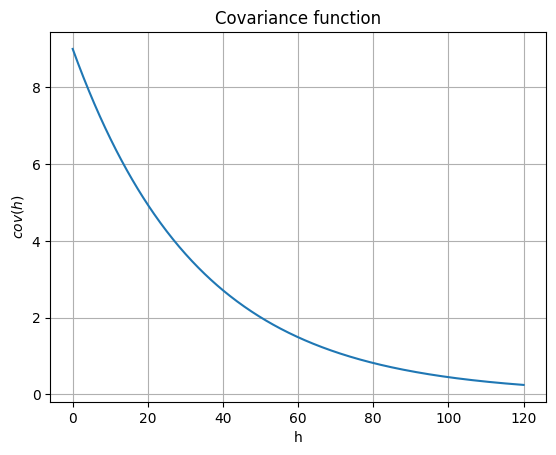

In [6]:
cov_model = gn.covModel.CovModel1D(elem=[
    ('exponential', {'w':9., 'r':100}), # elementary contribution
    ], name='model-1D example')


plt.figure()
cov_model.plot_model()
plt.title('Covariance function')
plt.show()

## 1. Example

### Settings - using data (optional) and probability (constant, optional)

In [7]:
if ncategory > 1:
    # Case with ncategory > 1
    # -----------------------
    # Data
    x = [50.5, 300.1, 550.2, 849.4]  # data locations (real coordinates)
    v = [ 1., 2., 1., 3.]            # data values
    # x = None
    # v = None

    # Probability, proportion of each category
    probability = [.1, .2, .7] # should sum to 1
    # probability = None

    # Type of kriging
    method = 'simple_kriging'

else:
    # Case with ncategory = 1
    # -----------------------
    # Data
    x = [50.5, 300.1, 550.2, 849.4]  # data locations (real coordinates)
    v = [ 0., 2., 2., 0.]            # data values
    # x = None
    # v = None

    # Probability, proportion (of non-zero category)
    probability = [.7] # list of one number in the interval [0, 1]
    # probability = None

    # Type of kriging
    method = 'simple_kriging'

### Estimation of probabilities (by kriging)

In [8]:
# Computational resources
nthreads = 8

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.estimateIndicator(
                            category_values,               # list of categories (required)
                            cov_model,                     # covariance model(s) (required)
                            nx, sx, ox,                    # grid geometry (nx is required)
                            x=x, v=v,                      # data
                            probability=probability,       # probability
                            method=method,                 # type of kriging
                            use_unique_neighborhood=True,  # search neighborhood ...
                            # searchRadius=None,             
                            # searchRadiusRelative=1.2, 
                            nneighborMax=12,
                            nthreads=nthreads,              # computational resources
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

krig_img = geosclassic_output['image'] # output image


estimateIndicator: Geos-Classic running on 1 process... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicIndicatorSim: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicIndicatorSim: Geos-Classic run complete
estimateIndicator: Geos-Classic (1 process) run complete
Elapsed time: 0.0034 sec


In [9]:
# Total number of warning(s), and warning messages
geosclassic_output['nwarning'], geosclassic_output['warnings']

(0, [])

In [10]:
# %%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Equivalent, using other computational resources
# -----------------------------------------------
# Computational resources
nthreads = 1

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.estimateIndicator(
                            category_values,               # list of categories (required)
                            cov_model,                     # covariance model(s) (required)
                            nx, sx, ox,                    # grid geometry (nx is required)
                            x=x, v=v,                      # data
                            probability=probability,       # probability
                            method=method,                 # type of kriging
                            use_unique_neighborhood=True,  # search neighborhood ...
                            # searchRadius=None,             
                            # searchRadiusRelative=1.2, 
                            nneighborMax=12,
                            nthreads=nthreads,              # computational resources
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

krig_img_2 = geosclassic_output['image'] # output image

print(f"Same results ? {np.allclose(krig_img.val, krig_img_2.val)}")


estimateIndicator: Geos-Classic running on 1 process... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 1 thread(s)]
run_MPDSOMPGeosClassicIndicatorSim: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 1 thread(s)]
run_MPDSOMPGeosClassicIndicatorSim: Geos-Classic run complete
estimateIndicator: Geos-Classic (1 process) run complete
Elapsed time: 0.0056 sec
Same results ? True


### Simulations

In [11]:
# Number of realizations
nreal = 1000

# Seed
seed = 321

# Computational resources
nproc = 2
nthreads_per_proc = 4

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulateIndicator(
                            category_values,               # list of categories (required)
                            cov_model,                     # covariance model(s) (required)
                            nx, sx, ox,                    # grid geometry (nx is required)
                            x=x, v=v,                      # data
                            probability=probability,       # probability
                            method=method,                 # type of kriging
                            searchRadius=None,             # search neighborhood ...
                            searchRadiusRelative=1.2, 
                            nneighborMax=12,
                            nreal=nreal,                   # number of realizations
                            seed=seed,                     # seed
                            nproc=nproc,                   # computational resources ...
                            nthreads_per_proc=nthreads_per_proc, 
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

simul_img = geosclassic_output['image'] # output image


simulateIndicator: Geos-Classic running on 2 process(es)... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
run_MPDSOMPGeosClassicIndicatorSim [pid=0]: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
run_MPDSOMPGeosClassicIndicatorSim [pid=0]: Geos-Classic run complete
simulateIndicator: Geos-Classic (2 process(es)) run complete
Elapsed time: 3.1 sec


In [12]:
# Total number of warning(s), and warning messages
geosclassic_output['nwarning'], geosclassic_output['warnings']

(0, [])

In [13]:
# %%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Equivalent, using other computational resources
# -----------------------------------------------
# Computational resources
nproc = 1
nthreads_per_proc = 1

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulateIndicator(
                            category_values,               # list of categories (required)
                            cov_model,                     # covariance model(s) (required)
                            nx, sx, ox,                    # grid geometry (nx is required)
                            x=x, v=v,                      # data
                            probability=probability,       # probability
                            method=method,                 # type of kriging
                            searchRadius=None,             # search neighborhood ...
                            searchRadiusRelative=1.2, 
                            nneighborMax=12,
                            nreal=nreal,                   # number of realizations
                            seed=seed,                     # seed
                            nproc=nproc,                   # computational resources ...
                            nthreads_per_proc=nthreads_per_proc, 
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

simul_img_2 = geosclassic_output['image'] # output image

print(f"Same results ? {np.allclose(simul_img.val, simul_img_2.val)}")


simulateIndicator: Geos-Classic running on 1 process... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 1 thread(s)]
run_MPDSOMPGeosClassicIndicatorSim: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 1 thread(s)]
run_MPDSOMPGeosClassicIndicatorSim: Geos-Classic run complete
simulateIndicator: Geos-Classic (1 process) run complete
Elapsed time: 13 sec
Same results ? True


### Plot the results

In [14]:
# Set sapcing (cell size) in y direction (1 cell in 1D) to visualize images using gn.imgplot.drawImage2D
sy = 0.2 * (simul_img.xmax() - simul_img.xmin())
simul_img.sy = sy
krig_img.sy = sy

if x is not None:
    # Set y-coordinates for conditioning data points for visualization
    y = len(x) * [simul_img.oy + 0.5*simul_img.sy]

In [15]:
# Compute proportion of each category (pixel-wise)
simul_img_prop = gn.img.imageCategProp(simul_img, category_values)

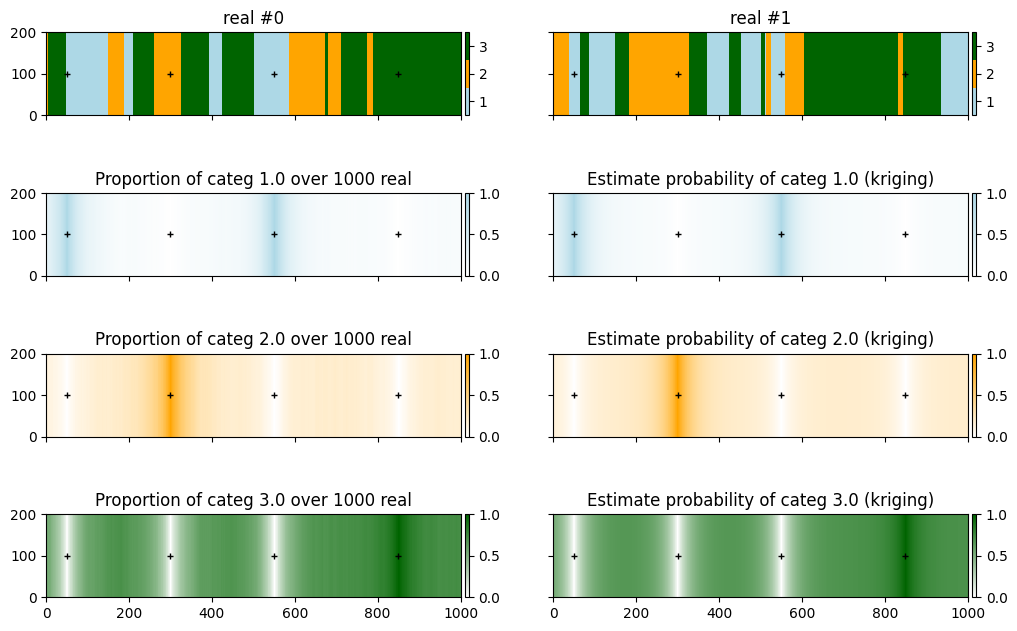

In [16]:
# Plot
plt.subplots(1+ncategory, 2, figsize=(12, 2*(1+ncategory)), sharex=True, sharey=True)

for i in range(2):
    plt.subplot(1+ncategory, 2, i+1)
    gn.imgplot.drawImage2D(simul_img, iv=i, categ=True, categVal=categVal, categCol=categCol)
    if x is not None:
        plt.plot(x, y, '+', c='black', markersize=5) # add conditioning point locations
    plt.title(f'real #{i}')

for i in range(ncategory):
    plt.subplot(1+ncategory, 2, 2*i+3)
    gn.imgplot.drawImage2D(simul_img_prop, iv=i, vmin=0, vmax=1, cmap=cmap_categ[i])
    if x is not None:
        plt.plot(x, y, '+', c='black', markersize=5) # add conditioning point locations
    plt.title(f'Proportion of categ {categVal[i]} over {nreal} real')

    plt.subplot(1+ncategory, 2, 2*i+4)
    gn.imgplot.drawImage2D(krig_img, iv=i, vmin=0, vmax=1, cmap=cmap_categ[i])
    if x is not None:
        plt.plot(x, y, '+', c='black', markersize=5) # add conditioning point locations
    plt.title(f'Estimate probability of categ {categVal[i]} (kriging)')

plt.show()

### Check results

In [17]:
# Check data
# ----------
if x is not None:
    # Get index of conditioning location in the grid
    data_grid_index = [gn.img.pointToGridIndex(xk, 0, 0, sx, 1., 1., ox, 0., 0.) for xk in x] # (ix, iy, iz) for each data point
    # Check estimation
    krig_v = [krig_img.val[:, iz, iy, ix] for ix, iy, iz in data_grid_index]
    if ncategory == 1:
        print(f'Estimation: all data respected ? {np.all(np.asarray(krig_v).reshape(-1) == np.asarray([1 if vi == category_values[0] else 0 for vi in v]))}')
    else:
        print(f'Estimation: all data respected ? {np.all([np.all(krig_v[i] == np.eye(ncategory)[np.where(np.asarray(category_values) == v[i])[0][0]]) for i in range(len(x))])}')
    # Check simulation
    sim_v = [simul_img.val[:, iz, iy, ix] for ix, iy, iz in data_grid_index]
    print(f'Simulation: all data respected ? {np.all([np.all(sim_v[i] == v[i]) for i in range(len(x))])}')


Estimation: all data respected ? True
Simulation: all data respected ? True


In [18]:
# Compare probabilities
# ---------------------
if probability is not None:
    print(f'Prescribed probabilities                                    = {probability}')
    print(f'Estimation: probabilities (mean over the grid)              = {krig_img.val.mean(axis=(1,2,3))}')
    print(f'Simulation: probabilities (mean over the grid and all real.)= {[np.mean(simul_img.val == cv) for cv in category_values]}')

Prescribed probabilities                                    = [0.1, 0.2, 0.7]
Estimation: probabilities (mean over the grid)              = [0.2000514  0.21483179 0.58511682]
Simulation: probabilities (mean over the grid and all real.)= [np.float64(0.189052), np.float64(0.214658), np.float64(0.59629)]


## 2. Example - using non-stationary probabilities

### Setting probability (proportion) maps

In [19]:
# Coordinates of the center of grid cells
xg = ox + sx*(0.5+np.arange(nx))

if ncategory > 1:
    # Case with ncategory > 1
    # -----------------------
    # Define probability maps for each category
    c = 0.9
    p1 = np.linspace(c, 0., nx)     
    p2 = c - p1
    p0 = (1. - c) * np.ones_like(p1) # 1.0 - p1 - p2 # constant map (0.1)

    probability = np.array((p0, p1, p2))

else:
    # Case with ncategory = 1
    # -----------------------
    c = 1.0
    # Define probability map for non-zero category
    probability = np.linspace(0., c, nx)



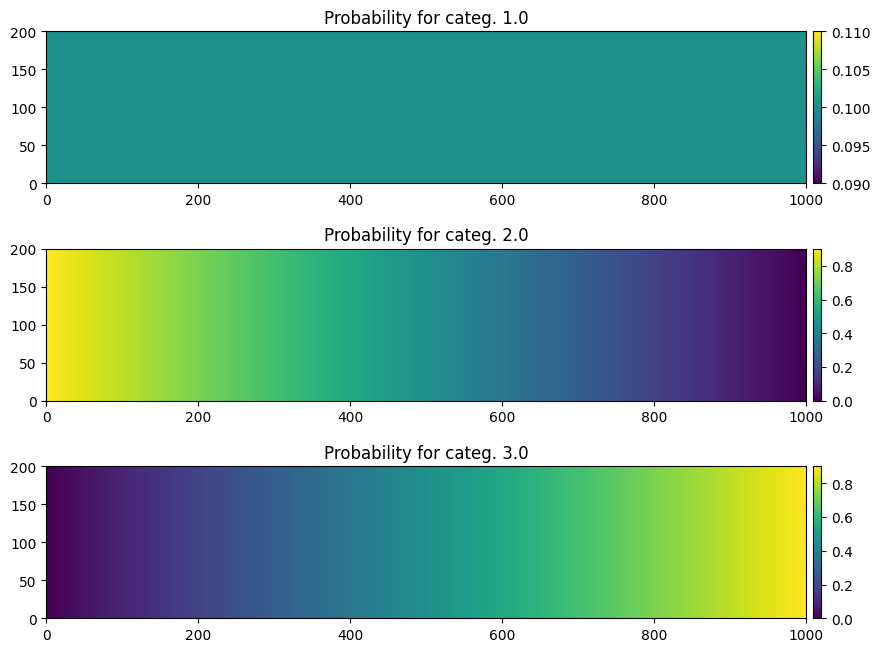

In [20]:
# Plot
# ----
# Fill image for display
probability_img = gn.img.Img(nx, 1, 1, sx, 1., 1., 0., 0., 0., nv=ncategory, val=probability)
probability_img.sy = .2 * probability_img.sx * probability_img.nx # set spacing in y direction (1 cell) to visualize images using gn.imgplot.drawImage2D

# Display probability maps
plt.subplots(ncategory, 1, figsize=(10,8), sharey=True)

for i in range(ncategory):
    plt.subplot(ncategory, 1, 1+i)
    gn.imgplot.drawImage2D(probability_img, iv=i, title = f'Probability for categ. {categVal[i]}')

plt.show()

### Settings - using data (optional)

In [21]:
if ncategory > 1:
    # Case with ncategory > 1
    # -----------------------
    # Data
    x = [50.5, 300.1, 550.2, 849.4]  # data locations (real coordinates)
    v = [ 1., 2., 1., 3.]            # data values
    # x = None
    # v = None

    # Probability : `probability` defined above

    # Type of kriging
    method = 'simple_kriging'

else:
    # Case with ncategory = 1
    # -----------------------
    # Data
    x = [50.5, 300.1, 550.2, 849.4]  # data locations (real coordinates)
    v = [ 0., 2., 2., 0.]            # data values
    # x = None
    # v = None

    # Probability : `probability` defined above

    # Type of kriging
    method = 'simple_kriging'

### Estimation of probabilities (by kriging)

In [22]:
# Computational resources
nthreads = 8

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.estimateIndicator(
                            category_values,               # list of categories (required)
                            cov_model,                     # covariance model(s) (required)
                            nx, sx, ox,                    # grid geometry (nx is required)
                            x=x, v=v,                      # data
                            probability=probability,       # probability
                            method=method,                 # type of kriging
                            use_unique_neighborhood=True,  # search neighborhood ...
                            # searchRadius=None,             
                            # searchRadiusRelative=1.2, 
                            nneighborMax=12,
                            nthreads=nthreads,              # computational resources
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

krig_img = geosclassic_output['image'] # output image


estimateIndicator: Geos-Classic running on 1 process... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicIndicatorSim: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicIndicatorSim: Geos-Classic run complete
estimateIndicator: Geos-Classic (1 process) run complete
Elapsed time: 0.0026 sec


In [23]:
# Total number of warning(s), and warning messages
geosclassic_output['nwarning'], geosclassic_output['warnings']

(0, [])

In [24]:
# %%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Equivalent, using other computational resources
# -----------------------------------------------
# Computational resources
nthreads = 1

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.estimateIndicator(
                            category_values,               # list of categories (required)
                            cov_model,                     # covariance model(s) (required)
                            nx, sx, ox,                    # grid geometry (nx is required)
                            x=x, v=v,                      # data
                            probability=probability,       # probability
                            method=method,                 # type of kriging
                            use_unique_neighborhood=True,  # search neighborhood ...
                            # searchRadius=None,             
                            # searchRadiusRelative=1.2, 
                            nneighborMax=12,
                            nthreads=nthreads,              # computational resources
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

krig_img_2 = geosclassic_output['image'] # output image

print(f"Same results ? {np.allclose(krig_img.val, krig_img_2.val)}")


estimateIndicator: Geos-Classic running on 1 process... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 1 thread(s)]
run_MPDSOMPGeosClassicIndicatorSim: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 1 thread(s)]
run_MPDSOMPGeosClassicIndicatorSim: Geos-Classic run complete
estimateIndicator: Geos-Classic (1 process) run complete
Elapsed time: 0.0068 sec
Same results ? True


### Simulations

In [25]:
# Number of realizations
nreal = 1000

# Seed
seed = 321

# Computational resources
nproc = 2
nthreads_per_proc = 4

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulateIndicator(
                            category_values,               # list of categories (required)
                            cov_model,                     # covariance model(s) (required)
                            nx, sx, ox,                    # grid geometry (nx is required)
                            x=x, v=v,                      # data
                            probability=probability,       # probability
                            method=method,                 # type of kriging
                            searchRadius=None,             # search neighborhood ...
                            searchRadiusRelative=1.2, 
                            nneighborMax=12,
                            nreal=nreal,                   # number of realizations
                            seed=seed,                     # seed
                            nproc=nproc,                   # computational resources ...
                            nthreads_per_proc=nthreads_per_proc, 
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

simul_img = geosclassic_output['image'] # output image


simulateIndicator: Geos-Classic running on 2 process(es)... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
run_MPDSOMPGeosClassicIndicatorSim [pid=0]: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
run_MPDSOMPGeosClassicIndicatorSim [pid=0]: Geos-Classic run complete
simulateIndicator: Geos-Classic (2 process(es)) run complete
Elapsed time: 3.1 sec


In [26]:
# Total number of warning(s), and warning messages
geosclassic_output['nwarning'], geosclassic_output['warnings']

(0, [])

In [27]:
# %%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Equivalent, using other computational resources
# -----------------------------------------------
# Computational resources
nproc = 1
nthreads_per_proc = 1

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulateIndicator(
                            category_values,               # list of categories (required)
                            cov_model,                     # covariance model(s) (required)
                            nx, sx, ox,                    # grid geometry (nx is required)
                            x=x, v=v,                      # data
                            probability=probability,       # probability
                            method=method,                 # type of kriging
                            searchRadius=None,             # search neighborhood ...
                            searchRadiusRelative=1.2, 
                            nneighborMax=12,
                            nreal=nreal,                   # number of realizations
                            seed=seed,                     # seed
                            nproc=nproc,                   # computational resources ...
                            nthreads_per_proc=nthreads_per_proc, 
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

simul_img_2 = geosclassic_output['image'] # output image

print(f"Same results ? {np.allclose(simul_img.val, simul_img_2.val)}")


simulateIndicator: Geos-Classic running on 1 process... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 1 thread(s)]
run_MPDSOMPGeosClassicIndicatorSim: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 1 thread(s)]
run_MPDSOMPGeosClassicIndicatorSim: Geos-Classic run complete
simulateIndicator: Geos-Classic (1 process) run complete
Elapsed time: 13 sec
Same results ? True


### Plot the results

In [28]:
# Set sapcing (cell size) in y direction (1 cell in 1D) to visualize images using gn.imgplot.drawImage2D
sy = 0.2 * (simul_img.xmax() - simul_img.xmin())
simul_img.sy = sy
krig_img.sy = sy

if x is not None:
    # Set y-coordinates for conditioning data points for visualization
    y = len(x) * [simul_img.oy + 0.5*simul_img.sy]

In [29]:
# Compute proportion of each category (pixel-wise)
simul_img_prop = gn.img.imageCategProp(simul_img, category_values)

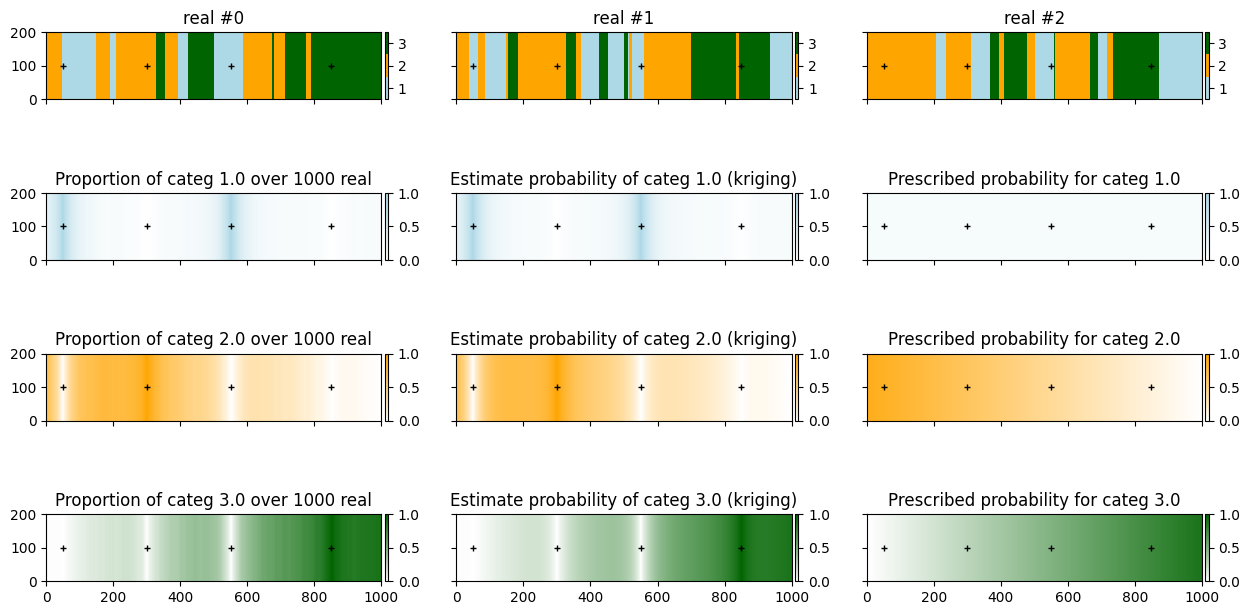

In [30]:
# Plot
plt.subplots(1+ncategory, 3, figsize=(15, (1+ncategory)*2), sharex=True, sharey=True)

for i in range(3):
    plt.subplot(1+ncategory, 3, i+1)
    gn.imgplot.drawImage2D(simul_img, iv=i, categ=True, categVal=categVal, categCol=categCol)
    if x is not None:
        plt.plot(x, y, '+', c='black', markersize=5) # add conditioning point locations
    plt.title(f'real #{i}')

for i in range(ncategory):
    plt.subplot(1+ncategory, 3, 3*i+4)
    gn.imgplot.drawImage2D(simul_img_prop, iv=i, vmin=0, vmax=1, cmap=cmap_categ[i])
    if x is not None:
        plt.plot(x, y, '+', c='black', markersize=5) # add conditioning point locations
    plt.title(f'Proportion of categ {categVal[i]} over {nreal} real')

    plt.subplot(1+ncategory, 3, 3*i+5)
    gn.imgplot.drawImage2D(krig_img, iv=i, vmin=0, vmax=1, cmap=cmap_categ[i])
    if x is not None:
        plt.plot(x, y, '+', c='black', markersize=5) # add conditioning point locations
    plt.title(f'Estimate probability of categ {categVal[i]} (kriging)')

    plt.subplot(1+ncategory, 3, 3*i+6)
    gn.imgplot.drawImage2D(probability_img, iv=i, vmin=0, vmax=1, cmap=cmap_categ[i])
    if x is not None:
        plt.plot(x, y, '+', c='black', markersize=5) # add conditioning point locations
    plt.title(f'Prescribed probability for categ {categVal[i]}')

plt.show()

### Check results

In [31]:
# Check data
# ----------
if x is not None:
    # Get index of conditioning location in the grid
    data_grid_index = [gn.img.pointToGridIndex(xk, 0, 0, sx, 1., 1., ox, 0., 0.) for xk in x] # (ix, iy, iz) for each data point
    # Check estimation
    krig_v = [krig_img.val[:, iz, iy, ix] for ix, iy, iz in data_grid_index]
    if ncategory == 1:
        print(f'Estimation: all data respected ? {np.all(np.asarray(krig_v).reshape(-1) == np.asarray([1 if vi == category_values[0] else 0 for vi in v]))}')
    else:
        print(f'Estimation: all data respected ? {np.all([np.all(krig_v[i] == np.eye(ncategory)[np.where(np.asarray(category_values) == v[i])[0][0]]) for i in range(len(x))])}')
    # Check simulation
    sim_v = [simul_img.val[:, iz, iy, ix] for ix, iy, iz in data_grid_index]
    print(f'Simulation: all data respected ? {np.all([np.all(sim_v[i] == v[i]) for i in range(len(x))])}')


Estimation: all data respected ? True
Simulation: all data respected ? True
